# ModelHub Template and SEIRD model example

This notebook implements the SEIRD Model using data from the covid19za data repository. 

*Authors:* Tshepiso Mokoena [Github: [@TshepisoMokoena](https://github.com/TshepisoMokoena)] & Vukosi Marivate [Github: [@vukosim](https://github.com/vukosi), Twitter: [@vukosi](https://twitter.com/vukosi)]
*Date:* 25 May 2020

### Model Description

TODO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

%matplotlib inline 

## SEIRD differential equations

* TODO: Reference

In [2]:
# SEIR Differenctial equations
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Load South Africa Data

In [3]:
za_confirmed_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
za_recoveries_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
za_deaths_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"

### ZA Confirmed Infections

In [4]:
df_za_infections = pd.read_csv(za_confirmed_url, parse_dates=['date'], dayfirst=True)
df_za_infections = df_za_infections[['date','total']]
df_za_infections.rename(columns={'total':'total_infections'}, inplace=True)
df_za_infections.set_index('date',inplace=True)
df_za_infections.head()

,total_infections
date,
2020-03-05,1
2020-03-07,2
2020-03-08,3
2020-03-09,7
2020-03-11,13


### ZA Recoveries

In [5]:
df_za_recoveries = pd.read_csv(za_recoveries_url, parse_dates=['date'], dayfirst=True)
df_za_recoveries = df_za_recoveries[['date','total']]
df_za_recoveries.rename(columns={'total':'total_recoveries'}, inplace=True)
df_za_recoveries.set_index('date',inplace=True)
df_za_recoveries.head()

,total_recoveries
date,
2020-04-17,903
2020-04-18,903
2020-04-19,903
2020-04-20,1055
2020-04-21,1055


### ZA Deaths

In [6]:
df_za_deaths = pd.read_csv(za_deaths_url, parse_dates=['date'], dayfirst=True)
df_za_deaths = df_za_deaths[['date','total']]
df_za_deaths.rename(columns={'total':'total_deaths'}, inplace=True)
df_za_deaths.set_index('date',inplace=True)
df_za_deaths.head()

,total_deaths
date,
2020-03-27,1
2020-03-28,2
2020-03-30,3
2020-03-31,5
2020-04-03,9


## Get Population Data

* TODO: Reference

In [7]:
population_url = "https://raw.githubusercontent.com/datasets/population/master/data/population.csv"
df_population = pd.read_csv(population_url)
display(df_population.head())


,Country Name,Country Code,Year,Value
0,Arab World,ARB,1960,92197753
1,Arab World,ARB,1961,94724510
2,Arab World,ARB,1962,97334442
3,Arab World,ARB,1963,100034179
4,Arab World,ARB,1964,102832760


## Main Model: Compute SEIRDs for South Africa

### Current Population Size

In [8]:
country = "South Africa"
N = df_population.loc[(df_population["Country Name"] == country) & (df_population["Year"] == 2018)]["Value"].values 
N

array([57779622], dtype=int64)

### Set initial conditions 

In [9]:
no_days_to_death = 14    # number of days to death after getting infection
D = 14                   # how many days infection lasts for
alpha = 0.002            # death rate
#no_days_to_death = 14    # How long an
incubation_period =  1   # number of days an exposed individual becomes infectiou

# Run One

### Get data from this date

In [10]:
date = "2020-05-29"
no_infections = df_za_infections.loc[date].values
no_deaths = df_za_deaths.loc[date].values
no_recoveries = df_za_recoveries.loc[date].values

print(no_infections)
print(no_deaths)
print(no_recoveries)

[29240]
[611]
[15093]


### The SEIRD Model - Initial Conditions

In [11]:
R_0 = no_infections/no_recoveries

gamma = 1.0 / D
delta = 1.0 / incubation_period     # incubation period of five days
beta = R_0 * gamma                  # R_0 = beta / gamma, so beta = R_0 * gamma
rho = 1/no_days_to_death            # days from infection until death    
S0, E0, I0, R0, D0 = N, 0, no_infections, no_recoveries, no_deaths  # initial conditions: one exposed

t = np.linspace(0, 600, 150) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions v

display(R_0)
display(t)
display(y0)

array([1.93732194])

array([  0.        ,   4.02684564,   8.05369128,  12.08053691,
        16.10738255,  20.13422819,  24.16107383,  28.18791946,
        32.2147651 ,  36.24161074,  40.26845638,  44.29530201,
        48.32214765,  52.34899329,  56.37583893,  60.40268456,
        64.4295302 ,  68.45637584,  72.48322148,  76.51006711,
        80.53691275,  84.56375839,  88.59060403,  92.61744966,
        96.6442953 , 100.67114094, 104.69798658, 108.72483221,
       112.75167785, 116.77852349, 120.80536913, 124.83221477,
       128.8590604 , 132.88590604, 136.91275168, 140.93959732,
       144.96644295, 148.99328859, 153.02013423, 157.04697987,
       161.0738255 , 165.10067114, 169.12751678, 173.15436242,
       177.18120805, 181.20805369, 185.23489933, 189.26174497,
       193.2885906 , 197.31543624, 201.34228188, 205.36912752,
       209.39597315, 213.42281879, 217.44966443, 221.47651007,
       225.5033557 , 229.53020134, 233.55704698, 237.58389262,
       241.61073826, 245.63758389, 249.66442953, 253.69

(array([57779622], dtype=int64),
 0,
 array([29240], dtype=int64),
 array([15093], dtype=int64),
 array([611], dtype=int64))

### Solve differential equation with chosen initial conditions

In [12]:
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
print(S)
print(E)
print(I)
print(R)
print(D)

[57779622.         57762855.9291202  57742073.47976829 57715717.82869115
 57682298.47234914 57639939.09543972 57586275.3358108  57518334.00498572
 57432386.28591972 57323771.56683076 57186689.84150933 57013963.07964254
 56796770.7243994  56524372.29960304 56183842.52843978 55759862.55882439
 55234635.67091713 54588026.42433578 53798053.98837934 52841893.19156209
 51697531.00376344 50346164.26658668 48775278.98834071 46982110.10787039
 44976878.88201754 42784945.75657609 40446975.4649097  38016520.39727744
 35555102.7784752  33125687.61496796 30786008.32768937 28583233.66806408
 26550942.29986311 24708583.3872659  23062927.26371058 21610680.14570686
 20341456.9361825  19240531.09298962 18291060.32729563 17475705.51146937
 16777697.13084032 16181461.83066448 15672930.94625665 15239636.92295587
 14870679.17360426 14556617.07330548 14289328.27402459 14061856.4958986
 13868262.47324029 13703485.52521386 13563219.08586408 13443801.02100501
 13342118.45134815 13255525.60191605 13181773.665585

### Plot SEIRD curves 

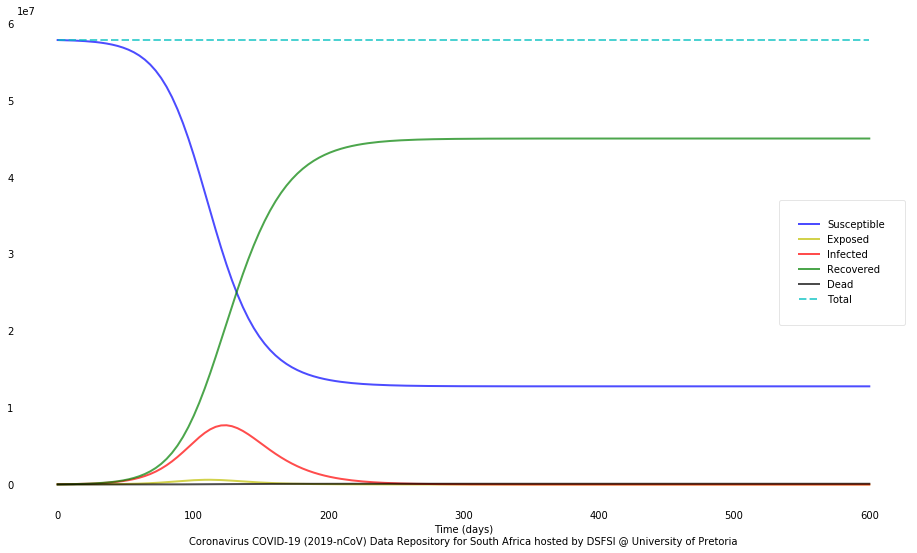

In [13]:
f, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
ax.set_xlabel('Time (days)\nCoronavirus COVID-19 (2019-nCoV) Data Repository for South Africa hosted by DSFSI @ University of Pretoria')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(borderpad=2.0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

# Run Two

### Get data from this date

In [14]:
date = "2020-06-04"
no_infections = df_za_infections.loc[date].values
no_deaths = df_za_deaths.loc[date].values
no_recoveries = df_za_recoveries.loc[date].values

print(no_infections)
print(no_deaths)
print(no_recoveries)

[40792]
[848]
[21311]


### The SEIRD Model - Initial Conditions

In [15]:
R_0 = no_infections/no_recoveries

gamma = 1.0 / D
delta = 1.0 / incubation_period     # incubation period of five days
beta = R_0 * gamma                  # R_0 = beta / gamma, so beta = R_0 * gamma
rho = 1/no_days_to_death            # days from infection until death    
S0, E0, I0, R0, D0 = N, 0, no_infections, no_recoveries, no_deaths  # initial conditions: one exposed

t = np.linspace(0, 600, 150) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions v

display(R_0)
display(t)
display(y0)

array([1.91412885])

array([  0.        ,   4.02684564,   8.05369128,  12.08053691,
        16.10738255,  20.13422819,  24.16107383,  28.18791946,
        32.2147651 ,  36.24161074,  40.26845638,  44.29530201,
        48.32214765,  52.34899329,  56.37583893,  60.40268456,
        64.4295302 ,  68.45637584,  72.48322148,  76.51006711,
        80.53691275,  84.56375839,  88.59060403,  92.61744966,
        96.6442953 , 100.67114094, 104.69798658, 108.72483221,
       112.75167785, 116.77852349, 120.80536913, 124.83221477,
       128.8590604 , 132.88590604, 136.91275168, 140.93959732,
       144.96644295, 148.99328859, 153.02013423, 157.04697987,
       161.0738255 , 165.10067114, 169.12751678, 173.15436242,
       177.18120805, 181.20805369, 185.23489933, 189.26174497,
       193.2885906 , 197.31543624, 201.34228188, 205.36912752,
       209.39597315, 213.42281879, 217.44966443, 221.47651007,
       225.5033557 , 229.53020134, 233.55704698, 237.58389262,
       241.61073826, 245.63758389, 249.66442953, 253.69

(array([57779622], dtype=int64),
 0,
 array([40792], dtype=int64),
 array([21311], dtype=int64),
 array([848], dtype=int64))

### Solve differential equation with chosen initial conditions

In [16]:
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
print(S)
print(E)
print(I)
print(R)
print(D)

ValueError: setting an array element with a sequence.

### Plot SEIRD curves 

In [ ]:
f, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
ax.set_xlabel('Time (days)\nCoronavirus COVID-19 (2019-nCoV) Data Repository for South Africa hosted by DSFSI @ University of Pretoria')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(borderpad=2.0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)